In [0]:
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.2)
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.14)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-mbmnxru3
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-mbmnxru3
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-u6spg7h6
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-u6spg7h6
     |████████████████████████████████| 266kB 5.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=47493 sha256=ed6bd4f7c7eef4e8680031c34dde6e6ee86177fb91b394c82232f84b7f1c4054
  Stored in directory: /tmp/pip-ephem-wheel-cache-13tasdgk/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel f

In [ ]:
# Restart runtime prior to this, to let installation take effect

# Some basic setup
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
import os
import sys

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Get Drive 
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Define a Mask-R-CNN model in Detectron2
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Detection Threshold 
cfg.MODEL.ROI_HEADS.NMS = 0.4 # Non Maximum Suppression Threshold 
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
model = DefaultPredictor(cfg)

WARNING [11/25 08:13:44 d2.config.compat]: Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


model_final_f10217.pkl: 178MB [00:10, 16.3MB/s]                           


In [0]:
# Playground 
im = cv2.imread("drive/My Drive/Bird_Classification/data/bird_dataset/train_images/004.Groove_billed_Ani/Groove_Billed_Ani_0004_1528.jpg")
outputs = model(im)

print(outputs["instances"].pred_classes)
print(outputs["instances"].scores)

tensor([14, 14], device='cuda:0')
tensor([0.9984, 0.8511], device='cuda:0')


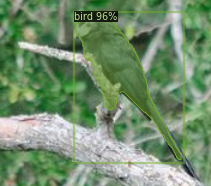

In [0]:
# Example - Plot a bounding box
from detectron2.utils.visualizer import Visualizer
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [0]:
def detect_birds(model, input_folder, output_folder):
  for data_folder in list(os.listdir(input_folder)): # Iterate over train, val and test
    non_cropped = 0
    non_cropped_names = []
    num_imgs = 0
    directory = input_folder+'/'+data_folder
    print("\nDetecting birds on :", data_folder)
    for folder in list(os.listdir(directory)): # Iterate over classes of birds
      size = len(list(os.listdir(directory+'/'+folder)))
      num_imgs += size
      os.makedirs(output_folder, exist_ok = True)
      os.makedirs(output_folder+'/'+data_folder+'/'+folder, exist_ok = True)

      img_paths = []          
      img_detections = [] 

      # Reformat weird images
      for file in os.listdir(directory+'/'+folder):
        i = plt.imread(directory+'/'+folder+'/'+file)
        if len(i.shape)==2 or i.shape[2]!=3:
          i = Image.fromarray(i)
          i = i.convert('RGB')
          i.save(directory+'/'+folder+'/'+file)
      del i
                
      # Get image paths and detections : not the most efficient way, but it avoids defining a proper detectron2-specific Dataloader 
      for img_path in list(os.listdir(directory+'/'+folder)):
        img = cv2.imread(directory+'/'+folder+'/'+img_path)
        with torch.no_grad():
          detections = model(img)["instances"]
        img_paths.append(directory+'/'+folder+'/'+img_path)
        img_detections.append(detections)

      # Save cropped images
      for (path, detections) in (zip(img_paths, img_detections)):
        img = np.array(Image.open(path))

        # Bounding boxes and labels of detections
        if len(detections.scores)>0:

          # Get the most probable bird prediction bounding box
          index_birds = np.where(detections.pred_classes.cpu().numpy()==14)[0] # 14 is the default class number for bird
          if len(index_birds)==0:
            # Flip the image if we are not able to detect the bird
            non_cropped_names.append(path)
            non_cropped += 1
            path = path.split("/")[-1]
            plt.imsave(output_folder+'/'+data_folder+'/'+folder+'/'+path, np.array(ImageOps.mirror(Image.fromarray(img))), dpi=1000)
            plt.close()  
            continue
          bird = int(torch.max(detections.scores[index_birds],0)[1].cpu().numpy())
          [x1,y1,x2,y2]=detections.pred_boxes[index_birds][bird].tensor[0].cpu().numpy()
          count=1

          # If we are able to detect the bird, enlarge the bounding box and generate a new image
          x1, y1 = np.maximum(0,int(x1)-20), np.maximum(0,int(y1)-20)
          x2, y2 = np.minimum(x2+40,img.shape[1]), np.minimum(y2+40,img.shape[0])
          img = img[int(np.ceil(y1)):int(y2), int(np.ceil(x1)):int(x2), :]

          # Save generated image with detections
          path = path.split("/")[-1]
          plt.imsave(output_folder+'/'+data_folder+'/'+folder+'/'+path, img, dpi=1000)
          plt.close()   
          
        else:
          # Flip the image if we are not able to detect the bird
          non_cropped_names.append(path)
          non_cropped+=1
          path = path.split("/")[-1]
          # Flip the image if we are not able to detect it
          plt.imsave(output_folder+'/'+data_folder+'/'+folder+'/'+path, np.array(ImageOps.mirror(Image.fromarray(img))), dpi=1000)
          plt.close()  

    print("\t{}% of {} images non cropped".format(np.round(100*non_cropped/num_imgs,2),data_folder))
  return(non_cropped_names)

In [0]:
non_cropped_paths = detect_birds(model = model, input_folder="drive/My Drive/Bird_Classification/data/bird_dataset", output_folder="drive/My Drive/Bird_Classification/data/crop_dataset")


Detecting birds on : train_images
	1.76% of train_images images non cropped

Detecting birds on : test_images
	3.63% of test_images images non cropped

Detecting birds on : val_images
	2.91% of val_images images non cropped


We can notice the difficulty of the test set, as our pre-trained on ImageNet detector Mask R-CNN fails to produce confident predictions for 3.63% of the test data. I have tried other detectors (notably Yolo3) but the Detectron2 implemented Mask R-CNN gave significantly better test performances for the same confidence threshold used here (while Yolo3 gave better validation performances). Furthermore, I quickly checked that this threshold guarantees very few mistakes.

In [0]:
def test_augmentation(input_folder, output_folder, flip = False, blur = False, contrast = 1.):
  for data_folder in list(os.listdir(input_folder)): 
    if "test_images" not in data_folder: # Only augment test data
      continue
    directory=input_folder+'/'+data_folder
    for folder in list(os.listdir(directory)): # Iterate over classes of birds
      os.makedirs(output_folder, exist_ok=True)
      os.makedirs(output_folder+'/'+data_folder, exist_ok=True)

      # Reformat weird images
      for file in os.listdir(directory+'/'+folder):
        i=plt.imread(directory+'/'+folder+'/'+file)
        if len(i.shape)==2 or i.shape[2]!=3:
          i=Image.fromarray(i)
          i=i.convert('RGB')
          i.save(directory+'/'+folder+'/'+file)
      del i
      
      # Transform the image
      for img_path in list(os.listdir(directory+'/'+folder)): 
        img = plt.imread(directory+'/'+folder+'/'+img_path)
        if flip:
          img = np.array(ImageOps.mirror(Image.fromarray(img)))
        if blur:
          img = np.array((Image.fromarray(img)).filter(ImageFilter.BLUR))
        if contrast!=1.:
          img = np.array(ImageEnhance.Contrast(Image.fromarray(img)).enhance(contrast))
        plt.imsave(output_folder+'/'+data_folder+'/'+folder+'/'+img_path, img, dpi = 1000)
        plt.close()

test_augmentation(input_folder="drive/My Drive/Bird_Classification/data/bird_dataset", output_folder="drive/My Drive/Bird_Classification/data/flip_bird_dataset", flip = True)
test_augmentation(input_folder="drive/My Drive/Bird_Classification/data/crop_dataset", output_folder="drive/My Drive/Bird_Classification/data/flip_crop_bird_dataset", flip = True)